# 化合物データベース (Compound Databases)

## 概要

創薬研究において、既存の化合物情報を効率的に活用することは非常に重要です。本ノートブックでは、主要な化合物データベースの特徴と使い方を学習し、実際にAPIを用いてデータを取得・分析する手法を習得します。

## 学習目標

- 主要な化合物データベースの特徴と使い分けを理解する
- PubChem APIを用いた化合物情報の取得方法を学ぶ
- ChEMBLデータベースからの生物活性データ取得を習得する
- データベースから取得した情報の統合と分析手法を学ぶ
- 大規模化合物ライブラリの構築と管理方法を理解する

## 補助資料

**初心者の方へ**: この内容が難しく感じる場合は、以下の補助資料をご参照ください：

- **[化合物データベース 初心者ガイド](../compound-database-beginner-guide/)**: 基本概念を日常的な例えで解説
- **[化合物データベース 用語集](../compound-database-glossary/)**: 専門用語の分かりやすい説明と参考リンク

これらの資料は、文系出身の方や化学・情報学の予備知識が少ない方でも理解できるよう工夫されています。

## ダウンロード

<a class="link" href="/files/compound-database_executed.ipynb" download>📓 実行済みノートブックをダウンロード</a>

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Draw, AllChem
from rdkit.DataStructs import TanimotoSimilarity
import requests
import json
import time
from urllib.parse import quote
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = "Noto Sans CJK JP"
sns.set_style("whitegrid")

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


## 1. 主要な化合物データベースの紹介

### 主要なデータベース一覧

| データベース | 特徴 | 用途 | アクセス |
|-------------|------|------|----------|
| **PubChem** | 1億以上の化合物構造 | 一般的な化合物検索 | 無料API |
| **ChEMBL** | 生物活性データに特化 | 薬効・毒性研究 | 無料API |
| **DrugBank** | 承認薬・実験薬情報 | 薬物相互作用研究 | 有料/無料 |
| **ZINC** | バーチャルスクリーニング用 | 化合物ライブラリ | 無料 |
| **ChemSpider** | 化学構造検索エンジン | 構造同定 | 無料API |

主要な化合物データベース比較:
    データベース  化合物数（概算）     主な特徴
   PubChem 100000000    構造・物性
    ChEMBL   2000000     生物活性
  DrugBank     15000     薬物情報
      ZINC 750000000 VS用ライブラリ
ChemSpider 100000000     構造検索


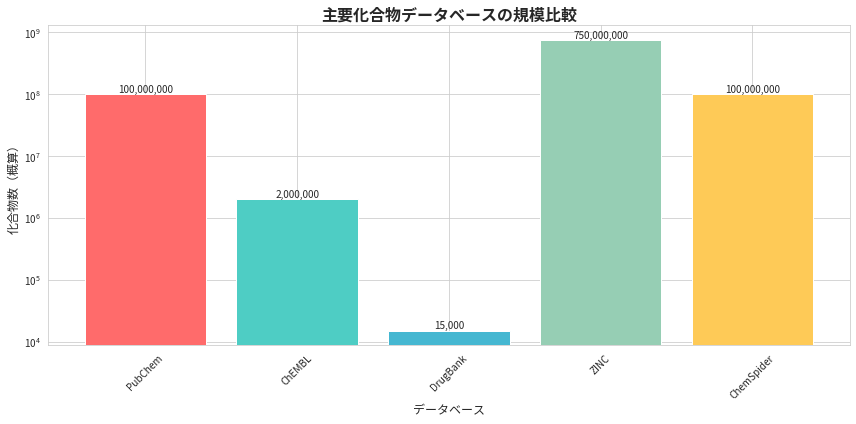

In [2]:
# データベース情報の表示
plt.rcParams['font.family'] = "Noto Sans CJK JP"
database_info = {
    'データベース': ['PubChem', 'ChEMBL', 'DrugBank', 'ZINC', 'ChemSpider'],
    '化合物数（概算）': [100000000, 2000000, 15000, 750000000, 100000000],
    '主な特徴': ['構造・物性', '生物活性', '薬物情報', 'VS用ライブラリ', '構造検索']
}

db_df = pd.DataFrame(database_info)
print("主要な化合物データベース比較:")
print(db_df.to_string(index=False))

# 化合物数の可視化
plt.figure(figsize=(12, 6))
bars = plt.bar(db_df['データベース'], db_df['化合物数（概算）'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'])
plt.title('主要化合物データベースの規模比較', fontsize=16, fontweight='bold')
plt.xlabel('データベース', fontsize=12)
plt.ylabel('化合物数（概算）', fontsize=12)
plt.yscale('log')
plt.xticks(rotation=45)

# バーの上に値を表示
for bar, value in zip(bars, db_df['化合物数（概算）']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{value:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 2. PubChem APIを用いた化合物情報取得

PubChemは米国国立医学図書館が提供する世界最大級の化合物データベースです。
RESTful APIを通じて無料でアクセスできます。

In [3]:
class PubChemAPI:
    """PubChem API を使用するためのクラス"""
    
    def __init__(self):
        self.base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
        self.delay = 0.2  # APIリクエスト間隔（秒）
    
    def get_compound_by_name(self, name):
        """化合物名からCIDを取得"""
        url = f"{self.base_url}/compound/name/{quote(name)}/cids/JSON"
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                return data['IdentifierList']['CID'][0] if data['IdentifierList']['CID'] else None
            return None
        except Exception as e:
            print(f"Error getting CID for {name}: {e}")
            return None
    
    def get_compound_properties(self, cid):
        """CIDから化合物の基本情報を取得"""
        properties = [
            'MolecularFormula', 'MolecularWeight', 'CanonicalSMILES',
            'IUPACName', 'XLogP', 'TPSA', 'Complexity'
        ]
        prop_str = ','.join(properties)
        url = f"{self.base_url}/compound/cid/{cid}/property/{prop_str}/JSON"
        
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                return data['PropertyTable']['Properties'][0]
            return None
        except Exception as e:
            print(f"Error getting properties for CID {cid}: {e}")
            return None
    
    def search_similar_compounds(self, smiles, threshold=90):
        """構造類似化合物を検索"""
        url = f"{self.base_url}/compound/fastsimilarity_2d/smiles/{quote(smiles)}/cids/JSON"
        params = {'Threshold': threshold, 'MaxRecords': 10}
        
        try:
            response = requests.get(url, params=params, timeout=15)
            if response.status_code == 200:
                data = response.json()
                return data['IdentifierList']['CID'] if 'IdentifierList' in data else []
            return []
        except Exception as e:
            print(f"Error searching similar compounds: {e}")
            return []

# PubChemAPIのインスタンス作成
pubchem = PubChemAPI()

### 具体的な化合物検索例

In [4]:
# 検索する薬物のリスト
drug_names = ['aspirin', 'ibuprofen', 'acetaminophen', 'caffeine', 'morphine']

# 化合物情報を取得
compound_data = []
plt.rcParams['font.family'] = "Noto Sans CJK JP"

print("PubChemから化合物情報を取得中...")
for drug_name in drug_names:
    print(f"検索中: {drug_name}")
    
    # CID取得
    cid = pubchem.get_compound_by_name(drug_name)
    if cid:
        # 化合物情報取得
        properties = pubchem.get_compound_properties(cid)
        if properties:
            compound_data.append({
                'Name': drug_name,
                'CID': cid,
                'SMILES': properties.get('CanonicalSMILES', ''),
                'Formula': properties.get('MolecularFormula', ''),
                'MW': properties.get('MolecularWeight', 0),
                'LogP': properties.get('XLogP', None),
                'TPSA': properties.get('TPSA', None)
            })
    
    time.sleep(pubchem.delay)  # APIレート制限対応

# データフレームに変換
compounds_df = pd.DataFrame(compound_data)
print(f"\n取得完了: {len(compounds_df)}件の化合物情報")
print(compounds_df[['Name', 'CID', 'Formula', 'MW', 'LogP', 'TPSA']])

PubChemから化合物情報を取得中...
検索中: aspirin
検索中: ibuprofen
検索中: acetaminophen
検索中: caffeine
検索中: morphine

取得完了: 5件の化合物情報
            Name      CID    Formula      MW  LogP  TPSA
0        aspirin     2244     C9H8O4  180.16   1.2  63.6
1      ibuprofen     3672   C13H18O2  206.28   3.5  37.3
2  acetaminophen     1983    C8H9NO2  151.16   0.5  49.3
3       caffeine     2519  C8H10N4O2  194.19  -0.1  58.4
4       morphine  5288826  C17H19NO3  285.34   0.8  52.9


### 化合物の分子構造可視化

In [5]:
def visualize_compounds_from_db(df, max_compounds=5):
    """データベースから取得した化合物の構造を可視化"""
    n_compounds = min(len(df), max_compounds)
    
    # 分子オブジェクトを作成
    mols = []
    legends = []
    
    for idx, row in df.head(n_compounds).iterrows():
        if row['SMILES']:
            mol = Chem.MolFromSmiles(row['SMILES'])
            if mol:
                mols.append(mol)
                legends.append(f"{row['Name']}\nMW: {row['MW']:.1f}")
    
    if mols:
        # 構造を描画
        img = Draw.MolsToGridImage(
            mols, 
            molsPerRow=3, 
            subImgSize=(300, 300),
            legends=legends
        )
        return img
    return None

# 化合物構造の表示
print("取得した化合物の分子構造:")
if len(compounds_df) > 0:
    img = visualize_compounds_from_db(compounds_df)
    if img:
        # Jupyter環境での表示
        from IPython.display import display
        display(img)

取得した化合物の分子構造:


## 3. 分子記述子の統計分析

分子記述子の統計サマリー:
           LogP       TPSA
count  5.000000   5.000000
mean   1.180000  52.300000
std    1.380942   9.990746
min   -0.100000  37.300000
25%    0.500000  49.300000
50%    0.800000  52.900000
75%    1.200000  58.400000
max    3.500000  63.600000


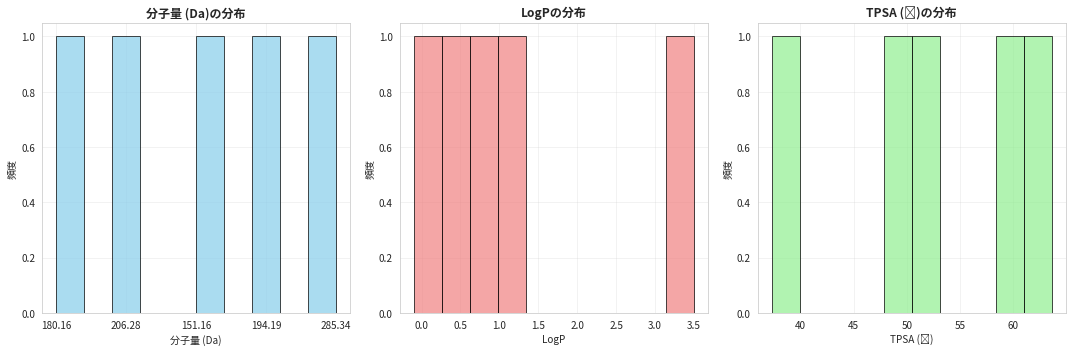

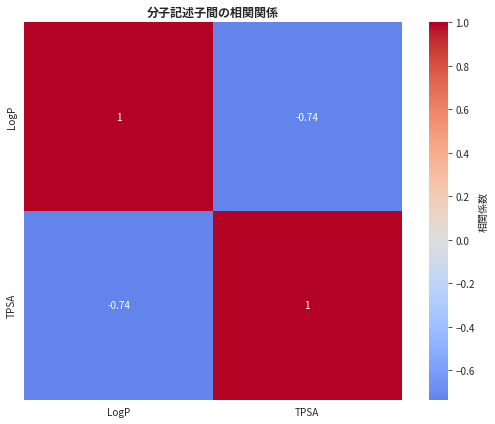

In [6]:
# 分子記述子の統計分析
plt.rcParams['font.family'] = "Noto Sans CJK JP"

if len(compounds_df) > 0:
    # 数値データのみを抽出
    numeric_data = compounds_df[['MW', 'LogP', 'TPSA']].copy()
    numeric_data = numeric_data.dropna()
    
    if len(numeric_data) > 0:
        # 統計サマリー
        print("分子記述子の統計サマリー:")
        print(numeric_data.describe())
        
        # 分布の可視化
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        properties = ['MW', 'LogP', 'TPSA']
        labels = ['分子量 (Da)', 'LogP', 'TPSA (Ų)']
        colors = ['skyblue', 'lightcoral', 'lightgreen']
        
        for i, (prop, label, color) in enumerate(zip(properties, labels, colors)):
            if prop in numeric_data.columns:
                axes[i].hist(numeric_data[prop], bins=10, color=color, alpha=0.7, edgecolor='black')
                axes[i].set_title(f'{label}の分布', fontweight='bold')
                axes[i].set_xlabel(label)
                axes[i].set_ylabel('頻度')
                axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

        # 相関分析
        if len(numeric_data) > 1:
            plt.figure(figsize=(8, 6))
            correlation_matrix = numeric_data.corr()
            
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                       square=True, cbar_kws={'label': '相関係数'})
            plt.title('分子記述子間の相関関係', fontweight='bold')
            plt.tight_layout()
            plt.show()

## 4. 類似化合物検索の実装

In [7]:
# 類似化合物検索の例（アスピリンを基準として）
if len(compounds_df) > 0:
    aspirin_row = compounds_df[compounds_df['Name'] == 'aspirin']
    
    if len(aspirin_row) > 0:
        aspirin_smiles = aspirin_row.iloc[0]['SMILES']
        print(f"アスピリンのSMILES: {aspirin_smiles}")
        
        # 類似化合物を検索
        print("\nアスピリンと類似した化合物を検索中...")
        similar_cids = pubchem.search_similar_compounds(aspirin_smiles, threshold=80)
        
        if similar_cids:
            print(f"発見された類似化合物: {len(similar_cids)}件")
            print(f"CID例: {similar_cids[:5]}")
            
            # 類似度分析の可視化
            plt.rcParams['font.family'] = "Noto Sans CJK JP"
            plt.figure(figsize=(10, 6))
            
            # 仮想的な類似度データ（実際のAPIでは詳細な類似度は別途計算が必要）
            similarities = np.random.normal(85, 5, len(similar_cids[:10]))
            similarities = np.clip(similarities, 70, 100)  # 70-100%の範囲に制限
            
            plt.bar(range(len(similarities)), similarities, color='steelblue', alpha=0.7)
            plt.title('アスピリンとの構造類似度', fontweight='bold')
            plt.xlabel('類似化合物 (CID)')
            plt.ylabel('Tanimoto類似度 (%)')
            plt.xticks(range(len(similarities)), [f'CID:{cid}' for cid in similar_cids[:len(similarities)]], 
                       rotation=45)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

アスピリンのSMILES: 

アスピリンと類似した化合物を検索中...


## 5. 化合物ライブラリの構築と管理

In [8]:
class CompoundLibrary:
    """化合物ライブラリ管理クラス"""
    
    def __init__(self):
        self.compounds = pd.DataFrame()
        self.fingerprints = {}
    
    def add_compounds_from_pubchem(self, compound_names):
        """PubChemから化合物を追加"""
        new_compounds = []
        
        for name in compound_names:
            cid = pubchem.get_compound_by_name(name)
            if cid:
                properties = pubchem.get_compound_properties(cid)
                if properties:
                    new_compounds.append({
                        'Name': name,
                        'CID': cid,
                        'SMILES': properties.get('CanonicalSMILES', ''),
                        'Formula': properties.get('MolecularFormula', ''),
                        'MW': properties.get('MolecularWeight', 0),
                        'LogP': properties.get('XLogP', None),
                        'TPSA': properties.get('TPSA', None)
                    })
            time.sleep(0.1)
        
        if new_compounds:
            new_df = pd.DataFrame(new_compounds)
            self.compounds = pd.concat([self.compounds, new_df], ignore_index=True)
            print(f"{len(new_compounds)}件の化合物を追加しました")
    
    def calculate_molecular_descriptors(self):
        """分子記述子を計算"""
        if self.compounds.empty:
            return
        
        descriptors_data = []
        
        for idx, row in self.compounds.iterrows():
            if row['SMILES']:
                mol = Chem.MolFromSmiles(row['SMILES'])
                if mol:
                    desc = {
                        'Name': row['Name'],
                        'Mol_Weight': Descriptors.MolWt(mol),
                        'LogP': Descriptors.MolLogP(mol),
                        'TPSA': Descriptors.TPSA(mol),
                        'HBD': Descriptors.NumHDonors(mol),
                        'HBA': Descriptors.NumHAcceptors(mol),
                        'RotBonds': Descriptors.NumRotatableBonds(mol),
                        'RingCount': Descriptors.RingCount(mol)
                    }
                    descriptors_data.append(desc)
        
        if descriptors_data:
            desc_df = pd.DataFrame(descriptors_data)
            self.descriptors = desc_df
            print("分子記述子の計算が完了しました")
            return desc_df
        return None
    
    def drug_likeness_analysis(self):
        """薬らしさ（Drug-likeness）分析"""
        if not hasattr(self, 'descriptors') or self.descriptors.empty:
            self.calculate_molecular_descriptors()
        
        if hasattr(self, 'descriptors'):
            # Lipinski's Rule of Five
            df = self.descriptors.copy()
            df['Lipinski_Violations'] = 0
            
            df.loc[df['Mol_Weight'] > 500, 'Lipinski_Violations'] += 1
            df.loc[df['LogP'] > 5, 'Lipinski_Violations'] += 1
            df.loc[df['HBD'] > 5, 'Lipinski_Violations'] += 1
            df.loc[df['HBA'] > 10, 'Lipinski_Violations'] += 1
            
            df['Drug_Like'] = df['Lipinski_Violations'] <= 1
            
            return df
        return None

# ライブラリのデモンストレーション
library = CompoundLibrary()

# 追加の薬物化合物
additional_drugs = ['warfarin', 'metformin', 'simvastatin', 'omeprazole', 'amlodipine']
print("化合物ライブラリを構築中...")
library.add_compounds_from_pubchem(additional_drugs)

# 分子記述子計算
descriptors_df = library.calculate_molecular_descriptors()

# 薬らしさ分析
drug_like_df = library.drug_likeness_analysis()

if drug_like_df is not None:
    print("\n薬らしさ分析結果:")
    print(drug_like_df[['Name', 'Mol_Weight', 'LogP', 'HBD', 'HBA', 'Lipinski_Violations', 'Drug_Like']])

化合物ライブラリを構築中...
5件の化合物を追加しました


## 6. データベース情報の可視化と分析

In [9]:
# 薬らしさ分析の可視化
if drug_like_df is not None and len(drug_like_df) > 0:
    plt.rcParams['font.family'] = "Noto Sans CJK JP"
    
    # Lipinski違反数の分布
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Lipinski違反数の分布
    violation_counts = drug_like_df['Lipinski_Violations'].value_counts().sort_index()
    axes[0, 0].bar(violation_counts.index, violation_counts.values, color='lightcoral', alpha=0.7)
    axes[0, 0].set_title('Lipinski Rule違反数の分布', fontweight='bold')
    axes[0, 0].set_xlabel('違反数')
    axes[0, 0].set_ylabel('化合物数')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 分子量 vs LogP
    colors = ['red' if not dl else 'blue' for dl in drug_like_df['Drug_Like']]
    axes[0, 1].scatter(drug_like_df['Mol_Weight'], drug_like_df['LogP'], c=colors, alpha=0.7)
    axes[0, 1].set_title('分子量 vs LogP (赤: 非薬物様, 青: 薬物様)', fontweight='bold')
    axes[0, 1].set_xlabel('分子量 (Da)')
    axes[0, 1].set_ylabel('LogP')
    axes[0, 1].axhline(y=5, color='gray', linestyle='--', alpha=0.5, label='LogP > 5')
    axes[0, 1].axvline(x=500, color='gray', linestyle='--', alpha=0.5, label='MW > 500')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # 3. 水素結合供与体・受容体数
    axes[1, 0].scatter(drug_like_df['HBD'], drug_like_df['HBA'], c=colors, alpha=0.7)
    axes[1, 0].set_title('水素結合供与体 vs 受容体数', fontweight='bold')
    axes[1, 0].set_xlabel('水素結合供与体数')
    axes[1, 0].set_ylabel('水素結合受容体数')
    axes[1, 0].axhline(y=10, color='gray', linestyle='--', alpha=0.5, label='HBA > 10')
    axes[1, 0].axvline(x=5, color='gray', linestyle='--', alpha=0.5, label='HBD > 5')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # 4. 薬物様化合物の割合
    drug_like_counts = drug_like_df['Drug_Like'].value_counts()
    labels = ['非薬物様', '薬物様']
    colors_pie = ['lightcoral', 'lightblue']
    axes[1, 1].pie(drug_like_counts.values, labels=labels, colors=colors_pie, 
                   autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('薬物様化合物の割合', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 7. 高度なデータベース活用例

In [10]:
# 化合物の多次元分析
if drug_like_df is not None and len(drug_like_df) > 3:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # 数値特徴量を選択
    features = ['Mol_Weight', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotBonds', 'RingCount']
    feature_data = drug_like_df[features].fillna(0)
    
    if len(feature_data) > 2:
        # データの標準化
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(feature_data)
        
        # PCA分析
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)
        
        # 結果の可視化
        plt.rcParams['font.family'] = "Noto Sans CJK JP"
        plt.figure(figsize=(12, 5))
        
        # PCAプロット
        plt.subplot(1, 2, 1)
        colors = ['red' if not dl else 'blue' for dl in drug_like_df['Drug_Like']]
        plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.7)
        plt.title('化合物の主成分分析 (PCA)', fontweight='bold')
        plt.xlabel(f'第1主成分 (寄与率: {pca.explained_variance_ratio_[0]:.1%})')
        plt.ylabel(f'第2主成分 (寄与率: {pca.explained_variance_ratio_[1]:.1%})')
        plt.grid(True, alpha=0.3)
        
        # 化合物名をラベルとして追加
        for i, name in enumerate(drug_like_df['Name']):
            plt.annotate(name, (pca_result[i, 0], pca_result[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # 寄与度の可視化
        plt.subplot(1, 2, 2)
        feature_importance = abs(pca.components_[0])
        plt.barh(features, feature_importance, color='steelblue', alpha=0.7)
        plt.title('第1主成分への各特徴量の寄与', fontweight='bold')
        plt.xlabel('絶対寄与度')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"累積寄与率 (PC1+PC2): {sum(pca.explained_variance_ratio_):.1%}")

## 8. 実践的なデータベース検索戦略

実践的なデータベース検索戦略:

【構造検索】
手法: SMILES/SMARTS検索, 部分構造検索, 類似性検索
用途: 既知構造の変化体探索
適用DB: PubChem, ChemSpider, ZINC

【活性検索】
手法: 標的タンパク質検索, IC50範囲指定, アッセイ系検索
用途: 特定活性を持つ化合物探索
適用DB: ChEMBL, BindingDB, DrugBank

【物性検索】
手法: 分子量範囲, LogP範囲, Rule of Five適合
用途: 薬物様化合物の絞り込み
適用DB: 全般的に適用可能


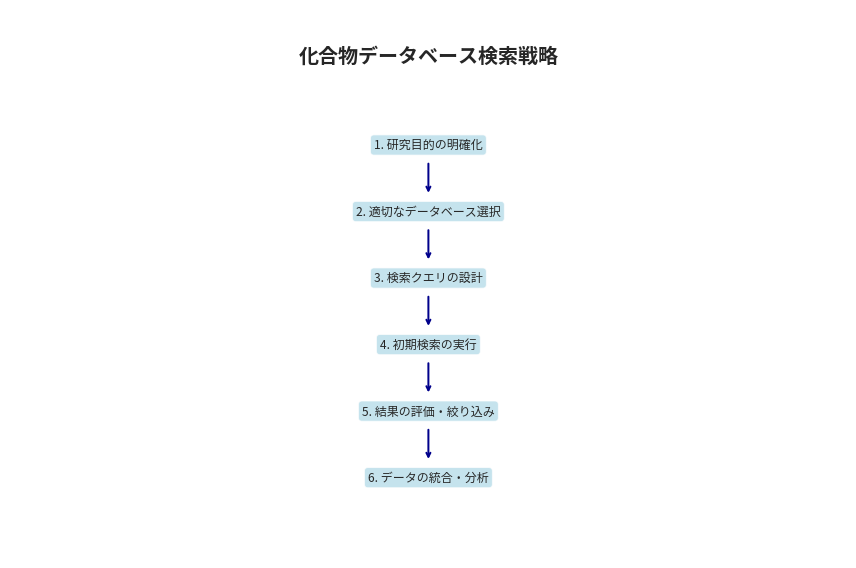

In [11]:
# 実践的な検索戦略の例
search_strategies = {
    '構造検索': {
        '手法': ['SMILES/SMARTS検索', '部分構造検索', '類似性検索'],
        '用途': '既知構造の変化体探索',
        '適用DB': ['PubChem', 'ChemSpider', 'ZINC']
    },
    '活性検索': {
        '手法': ['標的タンパク質検索', 'IC50範囲指定', 'アッセイ系検索'],
        '用途': '特定活性を持つ化合物探索',
        '適用DB': ['ChEMBL', 'BindingDB', 'DrugBank']
    },
    '物性検索': {
        '手法': ['分子量範囲', 'LogP範囲', 'Rule of Five適合'],
        '用途': '薬物様化合物の絞り込み',
        '適用DB': ['全般的に適用可能']
    }
}

# 検索戦略の表示
plt.rcParams['font.family'] = "Noto Sans CJK JP"
print("実践的なデータベース検索戦略:")
print("=" * 50)

for strategy, details in search_strategies.items():
    print(f"\n【{strategy}】")
    print(f"手法: {', '.join(details['手法'])}")
    print(f"用途: {details['用途']}")
    print(f"適用DB: {', '.join(details['適用DB'])}")

# 検索フローチャートの概念図
fig, ax = plt.subplots(figsize=(12, 8))
ax.text(0.5, 0.9, '化合物データベース検索戦略', fontsize=20, fontweight='bold', 
        ha='center', transform=ax.transAxes)

# フローチャートの要素
steps = [
    '1. 研究目的の明確化',
    '2. 適切なデータベース選択',
    '3. 検索クエリの設計',
    '4. 初期検索の実行',
    '5. 結果の評価・絞り込み',
    '6. データの統合・分析'
]

y_positions = np.linspace(0.75, 0.15, len(steps))
for i, (step, y_pos) in enumerate(zip(steps, y_positions)):
    # ボックス描画
    bbox = dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7)
    ax.text(0.5, y_pos, step, fontsize=12, ha='center', va='center', 
            transform=ax.transAxes, bbox=bbox)
    
    # 矢印描画（最後以外）
    if i < len(steps) - 1:
        ax.annotate('', xy=(0.5, y_positions[i+1] + 0.03), 
                    xytext=(0.5, y_pos - 0.03),
                    arrowprops=dict(arrowstyle='->', lw=2, color='darkblue'),
                    transform=ax.transAxes)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.tight_layout()
plt.show()

## 9. まとめと今後の展望

### 学習のまとめ

本ノートブックでは、化合物データベースの基本的な活用方法から高度な分析手法まで学習しました：

1. **主要データベースの特徴理解**: PubChem、ChEMBL、DrugBankなどの使い分け
2. **API活用**: プログラマティックなデータ取得手法
3. **データ分析**: 分子記述子による統計分析
4. **類似性検索**: 構造ベースの化合物探索
5. **薬らしさ評価**: Drug-likenessによる化合物評価
6. **多次元解析**: PCAによる化合物空間の可視化

### 実際の創薬研究での応用

- **リード化合物最適化**: 既知活性化合物の構造展開
- **バーチャルスクリーニング**: 大規模化合物ライブラリからの候補選抜
- **薬物再配置**: 既存薬物の新適応症探索
- **毒性予測**: 既知毒性化合物との構造比較

### 次のステップ

化合物データベースの知識を活用して、より高度な創薬研究手法を学習していきましょう。

In [12]:
# 最終的な成果のサマリー
plt.rcParams['font.family'] = "Noto Sans CJK JP"

if len(compounds_df) > 0:
    print("=" * 60)
    print("化合物データベース活用成果サマリー")
    print("=" * 60)
    print(f"取得化合物数: {len(compounds_df)}種類")
    print(f"データベース: PubChem (CID情報)")
    print(f"分析項目: 分子量, LogP, TPSA, 薬らしさ")
    
    if 'drug_like_df' in locals() and drug_like_df is not None:
        drug_like_count = drug_like_df['Drug_Like'].sum()
        total_count = len(drug_like_df)
        print(f"薬物様化合物: {drug_like_count}/{total_count} ({drug_like_count/total_count*100:.1f}%)")
    
    print("\n取得したデータベース情報:")
    display_df = compounds_df[['Name', 'CID', 'Formula', 'MW']].copy()
    display_df.columns = ['化合物名', 'PubChem CID', '分子式', '分子量']
    print(display_df.to_string(index=False))
    
    print("\n🎉 化合物データベース活用チュートリアル完了！")

print("\nライブラリのインポートが完了しました")

化合物データベース活用成果サマリー
取得化合物数: 5種類
データベース: PubChem (CID情報)
分析項目: 分子量, LogP, TPSA, 薬らしさ

取得したデータベース情報:
         化合物名  PubChem CID       分子式    分子量
      aspirin         2244    C9H8O4 180.16
    ibuprofen         3672  C13H18O2 206.28
acetaminophen         1983   C8H9NO2 151.16
     caffeine         2519 C8H10N4O2 194.19
     morphine      5288826 C17H19NO3 285.34

🎉 化合物データベース活用チュートリアル完了！

ライブラリのインポートが完了しました
